# `supplychain` module

## Introduction

This tutorial shows how to use the `supplychain` module of CLIMADA. This class allows assessing indirect economic impacts via Input-Output (IO) based modeling.

This tutorial assumes you are familiar with direct impact computation with CLIMADA with the [`Exposures`](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_Exposures.html), [`Hazard`](https://climada-python.readthedocs.io/en/stable/tutorial/climada_hazard_Hazard.html) and [`Impact`](https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_Impact.html) classes. Likewise, this tutorial assumes you are familiar with IO based modeling[^ft1].

To avoid an unnecessarily dense tutorial we cover the basic functionality, but a lot of methods and functions presented here offer some advanced uses, for which you can find documentation via the API reference and their docstring.

[^ft1]: We recommend the following book: Miller, R. E., & Blair, P. D. (2009). Input-Output Analysis: Foundations and Extensions (2nd ed.). Cambridge: Cambridge University Press.

## Goal of this tutorial

The goal of this tutorial is to present **indirect** impact computations for the different available approaches, by presenting how to set up a global supply chain risk analysis for tropical cyclones hitting japan.

## What approaches are available?

Here, we **briefly** describe the available approaches. We **strongly** advise you to find more detailed documentation online or in the literature if you are not familiar with these concepts.

### Leontief

The Leontief approach to conducting an indirect impact assessment involves using a Multi-Regional Input Output Table (MRIOT) to quantify the ripple effects of a **change in final demand** throughout the economy. The key steps are:

1. Obtain the Leontief inverse matrix from the intermediate demand matrix of the MRIOT (or transaction matrix), which represents the total (direct and indirect) requirements of each sector per unit of final demand. This captures the interdependencies between different sectors.
2. Multiply the Leontief inverse matrix by the change in final demand (the "exogenous variable") to calculate the indirect impacts on production in each sector.
3. The indirect effects analysis assesses the secondary needs arising from interactions among different sectors, considering the infinite iterations within the production system.
4. This allows for a comprehensive assessment of the indirect impacts beyond the first-order, direct impacts of the change in final demand.

### Ghosh

The Ghosh approach to conducting an indirect impact assessment is similar to the Leontief approach, but with some key differences:

1. The Ghosh model focuses on the supply-side of the economy, rather than the demand-side as in the Leontief model. It analyzes the impacts of changes in primary inputs (most often the value-added, which is what we use in the module) on the output of each sector.
2. The Ghosh inverse matrix represents the total (direct and indirect) output requirements per unit of primary input, capturing the forward linkages in the production system.
3. To assess the indirect impacts, the Ghosh inverse matrix is multiplied by the change in primary inputs (the "exogenous variable") to calculate the resulting changes in sectoral outputs.

Note however, that the Ghosh model has been criticized for its lack of economic plausibility, as it assumes that consumption is unresponsive to changes in income. Which is considered an unrealistic assumption.

### ARIO (with the `boario` package)

ARIO stands for Adaptive Regional Input-Output. It is an hybrid input-output agent-based dynamic economic model, designed to compute indirect costs from economic shocks.
Its first version dates back to 2008 and has originally been developed to assess the indirect costs of natural disasters [[Hallegatte 2008](https://doi.org/10.1111/j.1539-6924.2008.01046.x), [Hallegatte 2013](https://doi.org/10.1111/risa.12090)].

CLIMADA employs the [`boario`](https://spjuhel.github.io/BoARIO/boario-what-is.html) python package which implements the ARIO model.

Here are its keys elements:

- The economy is modelled as a set of economic sectors and a set of regions (the initial equilibrium state of the economy is built based on a MRIOT).
- Each economic sector produces its generic product and draws inputs from an inventory.
- Each sector answers to a total demand consisting of a final demand (household consumption, public spending and private investments) of all regions (local demand and exports) and intermediate demand (through input inventory resupply).

The model then describes how exogenous shocks propagate across the economy at each time step.



## Tutorial

In [1]:
import numpy as np
import pandas as pd

from climada.engine.impact_calc import ImpactCalc
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.util.api_client import Client
from climada_petals.engine.supplychain import DirectShocksSet, StaticIOModel, BoARIOModel, get_mriot
import datetime as dt

client = Client()

ERROR 1: PROJ: proj_create_from_database: Open of /home/sjuhel/miniforge3/envs/petals_supply_chain/share/proj failed
/home/sjuhel/miniforge3/envs/petals_supply_chain/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


### Calculate direct economic impacts

The first step is to conduct a direct impact analysis. To do so, we need to define an exposure, a hazard and a vulnerability. In this tutorial we will load the LitPop exposure for Japan from the CLIMADA Data API.

In [2]:
exp_jpn = client.get_litpop('JPN')

2025-02-11 15:07:34,658 - climada.entity.exposures.base - INFO - Reading /home/sjuhel/climada/data/exposures/litpop/LitPop_150arcsec_JPN/v3/LitPop_150arcsec_JPN.hdf5


Then, we load tropical cyclones that hit the Japan in 2019 from the CLIMADA Data API.

In [3]:
tc_jpn = client.get_hazard('tropical_cyclone', properties={'country_iso3alpha':'JPN', 'event_type': 'observed'})

target_year = 2019
events_in_target_year = np.array([
    tc_jpn.event_name[i] for i in range(len(tc_jpn.event_name)) if
    dt.datetime.fromordinal(tc_jpn.date[i]).year == target_year
    ])

tc_jpn_target_year = tc_jpn.select(event_names = events_in_target_year)

2025-02-11 15:07:52,118 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_0synth_tracks_150arcsec_historical_JPN_1980_2020/v2/tropical_cyclone_0synth_tracks_150arcsec_historical_JPN_1980_2020.hdf5


Then we define vulnerability by loading impact functions for tropical cyclones:

In [4]:
# Define impact function
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet()
impf_set.append(impf_tc)
impf_set.check()

And we finally calculate impacts.

In [5]:
# Calculate direct impacts to Japan due to TC
imp_calc = ImpactCalc(exp_jpn, impf_set, tc_jpn_target_year)
direct_impact_jpn = imp_calc.impact()

2025-02-11 15:07:52,240 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2025-02-11 15:07:52,242 - climada.entity.exposures.base - INFO - Matching 21999 exposures with 21962 centroids.
2025-02-11 15:07:52,248 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-02-11 15:07:52,275 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1 coordinates.
2025-02-11 15:07:52,277 - climada.engine.impact_calc - INFO - Calculating impact for 65976 assets (>0) and 111 events.


### Load a Multi Regional Input Output Table (MRIOT)

At the core of Input Output modeling lies (Multi-Regional) Input-Output Tables, or MRIOTs, a depiction of the economy production structure over multiple regions.

This module uses the [pymrio](https://pymrio.readthedocs.io/en/latest/) python package and custom functions to download, parse and save MRIOTs automatically. 
Currently supported tables are:
- [EXIOBASE3](https://zenodo.org/record/3583071#.Y_4zZuzMK3I) (1995-2020; 44 countries; 163 industries)
- [WIOD16](https://www.rug.nl/ggdc/valuechain/wiod/) (2000-2014; 43 countries; 56 industries)
- [OECD23](https://www.oecd.org/sti/ind/inter-country-input-output-tables.htm) (1995-2020; 66 countries; 45 industries)
- [EORA26](https://worldmrio.com/eora26/) [^fn2]

[^fn2]: Note that as EORA26 requires connection to an account to be downloaded, you need to download the files yourself and put them in the climada data folder. Parsing is still automatically handled.

To load an MRIOT from the available ones, simply use:

In [6]:
mriot = get_mriot("WIOD16", mriot_year=2010)

Note that the first time this function is called for a specific MRIOT and year, it requires to download and parse the file. By default, the function then saves the parsed data in the climada data folder, which greatly speeds up subsequent calls to the function.

`mriot` is a `pymrio.IOSystem`, representing a Multi-Regional Input Output Table (MRIOT). You can have a look at [pymrio's documentation](https://pymrio.readthedocs.io/en/latest/) to better understand this object.

Here are some important available attributes or methods, which you can have a look at:

- mriot.Z : the inter-industry flow matrix (also named intermediate demand or transaction matrix), i.e., the absolute flow of goods from region,sector to region,sector (used to produce new goods) in monetary terms.
- mriot.Y : the final demand matrix, i,e, the absolute flow of goods from region,sector to region (used as final products by consummers) in monetary terms. Often subdivided into final demand categories (state, households, etc).
- mriot.x : the absolute total amout of goods produced by each region, sector, should be equal to the sum of Z and Y (summing the columns together)
- mriot.A : the technical coefficient matrix
- mriot.get_sectors() : the sector typology
- mriot.get_regions() : the region typology

### Instantiate a DirectShocksSet object

In order to evaluate indirect economic impacts from an Impact object, we first need to translate that object which defines impacts per centroid (coordinates) into an object which defines impacts on industries ((region, sector) couples). This modules implements a `DirectShocksSet` for that very purpose: a set of direct shocks on the economy (one for each event held by the `Impact` object).

To do this we need to map the geographic exposure and impact to a) the countries or regions of the MRIOT and b) its sectors.

Mapping to countries is straightforward, as exposure contains latitude and longitude information, and even a regional id. Thus the region mapping is done automatically for EXIOBASE3, WIOD16 and OECD23 MRIOTs. For custom defined MRIOTs, it will work if the countries of the MRIOT are in ISO3 format.

Mapping to sectors is done by selecting the sectors assumed to be impacted and distributing the impact to the sectors. The default distribution is made proportionaly to each sector's production.

Results are completely dependant on this modeling choice which require carefull consideration.

The minimum requirements to instantiate a `DirectShocksSet` are:
- a MRIOT (in the form of a `pymrio.IOSystem`,
- an `Exposures` object,
- an `Impact` object,

In addition it is strongly advised to also give:
- the list of sectors affected by the `Impact`,
- and how the impact is distributed to the sectors.

Further note that exposure values are converted to the "monetary factor" of the MRIOT, assuming they are in unit value in exposure. For instance, EXIOBASE3 is in millions, so exposure values are divided by 1'000'000.

In [7]:
direct_shocks = DirectShocksSet.from_exp_and_imp(
    mriot=mriot,
    exposure=exp_jpn,
    impact=direct_impact_jpn,
    shock_name="TCs in JPN",
    affected_sectors=["Forestry and logging","Manufacture of motor vehicles, trailers and semi-trailers", "Mining and quarrying"],
    impact_distribution=None,  # None distribute the impact proportionally to the production of each impacted sectors
)

2025-02-11 15:07:53,292 - climada.util.coordinates - INFO - Setting region_id 21999 points.


You can have a look at the different attributes and methods available (mainly those not starting by "_"):

In [8]:
[avail for avail in direct_shocks.__dir__() if avail[0] != "_"]

['mriot_sectors',
 'mriot_regions',
 'mriot_industries',
 'event_ids',
 'mriot_name',
 'monetary_factor',
 'name',
 'exposure_assets',
 'impacted_assets',
 'event_dates',
 'relative_impact',
 'from_exp_and_imp',
 'from_assets_and_imp',
 'event_ids_with_impact',
 'impacted_assets_not_null',
 'exposure_assets_not_null',
 'combine']

This object stores the "translated" exposure and impact as `pd.Series` and `pd.DataFrame`.

Note that both the translated exposure and impacts use the full typology of regions and sectors from the MRIOT, which results in multiple null values. For convenience, you can access filtered version of the `Series`/`DataFrame` via:

In [11]:
direct_shocks.exposure_assets_not_null

region  sector                                                   
JPN     Forestry and logging                                         3.760612e+05
        Manufacture of motor vehicles, trailers and semi-trailers    1.692583e+07
        Mining and quarrying                                         1.603689e+06
dtype: float64

In [ ]:
direct_shocks.impacted_assets_not_null

Most approaches use the `relative_impact` as a basis for the shock, which is defined as the amount of impacted assets over the amount of exposure assets:

In [40]:
direct_shocks.relative_impact_not_null

region                    JPN  \
sector   Forestry and logging   
event_id                        
3236             8.378554e-10   
3242             1.401655e-05   
3243             2.835774e-08   
3244             1.019442e-04   
3248             2.183265e-03   
3250             5.450860e-06   
3253             5.869611e-04   
3254             7.997938e-11   
3255             1.855508e-02   
3257             4.056513e-09   

region                                                              \
sector   Manufacture of motor vehicles, trailers and semi-trailers   
event_id                                                             
3236                                           8.378554e-10          
3242                                           1.401655e-05          
3243                                           2.835774e-08          
3244                                           1.019442e-04          
3248                                           2.183265e-03          
3250                                           5.450860e-06          
3253                                           5.869611e-04          
3254                                           7.997938e-11          
3255                                           1.855508e-02          
3257                                           4.056513e-09          

region                         
sector   Mining and quarrying  
event_id                       
3236             8.378554e-10  
3242             1.401655e-05  
3243             2.835774e-08  
3244             1.019442e-04  
3248             2.183265e-03  
3250             5.450860e-06  
3253             5.869611e-04  
3254             7.997938e-11  
3255             1.855508e-02  
3257             4.056513e-09

#### Combining multiple DirectShocksSet

In the possible case that you have different source of exposure data for different sectors, you can define multiple `DirectShocksSet` (each corresponding to the impacts of the same events but over different exposure), and combine them into one single `DirectShocksSet` using the `combine` class method, for instance, assuming `exp_jpn_forestry` and `exp_jpn_mining` are Exposures object defining exposure data for the Forestry sector and the Mining sector respectively:

```python
direct_shocks_forestry = DirectShocksSet.from_exp_and_imp(
    mriot=mriot,
    exposure=exp_jpn_forestry,
    impact=direct_impact_jpn,
    shock_name="TCs in JPN on forestry",
    affected_sectors=["Forestry and logging"],
    impact_distribution=None,  # None distribute the impact proportionally to the production of each impacted sectors

direct_shocks_mining = DirectShocksSet.from_exp_and_imp(
    mriot=mriot,
    exposure=exp_jpn_mining,
    impact=direct_impact_jpn,
    shock_name="TCs in JPN on mining",
    affected_sectors=["Mining and quarrying"],
    impact_distribution=None,  # None distribute the impact proportionally to the production of each impacted sectors

direct_shocks = DirectShocksSet.combine([direct_shocks_forestry,direct_shocks_mining], kind="merge")
)
```

This `combine` method can also be used with `kind="concat"`, to concatenate `DirectShocksSet` from different impacts into one.

#### Defining custom `DirectShocksSet`

You can also define `DirectShocksSet` directly with a Series of exposure assets:

```python
exposure_assets = pd.Series([your_exposure_data], 
                            index=pd.MultiIndex.from_product(
                                [list_of_regions, list_of_sectors],
                                names=["region","sectors"]
                            )
                           )
direct_shocks = DirectShocksSet.from_assets_and_imp(exposure_assets=exposure_assets,
                                    impact=your_Impact_object,
                                    affected_sectors=your_list_of_affected_sectors,
                                    impact_distribution=your_impact_distribution
                                   )
```

### Leontief (and Ghosh) static models

The mathematical idea behind Input-Output (I-O) analysis revolves around using linear algebra to represent the interconnections between industries in an economy. It’s based on the Leontief model, named after economist Wassily Leontief, who developed the theory circa 1960.

The main goal is to see how changes in demand affect the entire economic system by solving for the total output required to meet that demand, through the "Leontief inverse". This matrix shows how a change in final demand for one industry’s output affects the overall economy (assuming the "recipes" of production and the trade relationship remain the same).

In the Ghosh model, the focus is on how changes in the supply of inputs (like raw materials or labor) affect the total output of industries.
Note however that the Ghosh model assumes a supply-driven economie, which is in general not verified. Thus results with this approach should be taken with caution.

In the module we employ the already well implemented methods of the `pymrio` package to compute these indirect effects. For the Leontief approach, the change (decrease) in final demand is computed as the `relative_impact` times the original final demand. For the Ghosh approach, the change (decrease) in value added is computed as the `relative_impact` times the original value added.

In [41]:
model = StaticIOModel(mriot, direct_shocks)

Computation of the indirect impacts is straightforward:

In [42]:
res = model.calc_indirect_impacts()

`res` is a pd.DataFrame which contains the results per (event, region, sector, method), for both the Leontief approach (shock assumed as a degraded demand) and the Ghosh approach (shock assumed as a degraded value added), and for three different metrics:

1. absolute production change: the absolute loss or gain of production
2. relative production change: the change in production relative to the original production in the MRIOT
3. production lost to shock ratio: the change in production relative to the direct impact on the (region,sector) (with 0 if the sector wasn't direclty shocked).

By default, only events with non null (direct) impacts are considered. To include all events, you can use `model.calc_indirect_impacts(event_event_ids=None)`. You can also compute for a specific set of events with `model.calc_indirect_impacts(event_event_ids=[<list of event ids>])`

In [43]:
res

,event_id,region,sector,method,metric,value
0,3236,AUS,Accommodation and food service activities,ghosh,absolute production change,-9.897446e-08
1,3236,AUS,Accommodation and food service activities,ghosh,production lost to sector shock ratio,0.000000e+00
2,3236,AUS,Accommodation and food service activities,ghosh,production lost to total shock ratio,-6.248332e-06
3,3236,AUS,Accommodation and food service activities,ghosh,relative production change,-1.487147e-12
4,3236,AUS,Accommodation and food service activities,leontief,absolute production change,-2.236537e-08
...,...,...,...,...,...,...
197115,3257,USA,"Wholesale trade, except of motor vehicles and ...",ghosh,relative production change,-3.018526e-13
197116,3257,USA,"Wholesale trade, except of motor vehicles and ...",leontief,absolute production change,-1.634949e-06
197117,3257,USA,"Wholesale trade, except of motor vehicles and ...",leontief,production lost to sector shock ratio,0.000000e+00
197118,3257,USA,"Wholesale trade, except of motor vehicles and ...",leontief,production lost to total shock ratio,-2.131873e-05


The tidy format of the results allows for easy plotting and data manipulation.

#### Top ten impacted sectors in Japan (relative to their production), with the Leontief method:

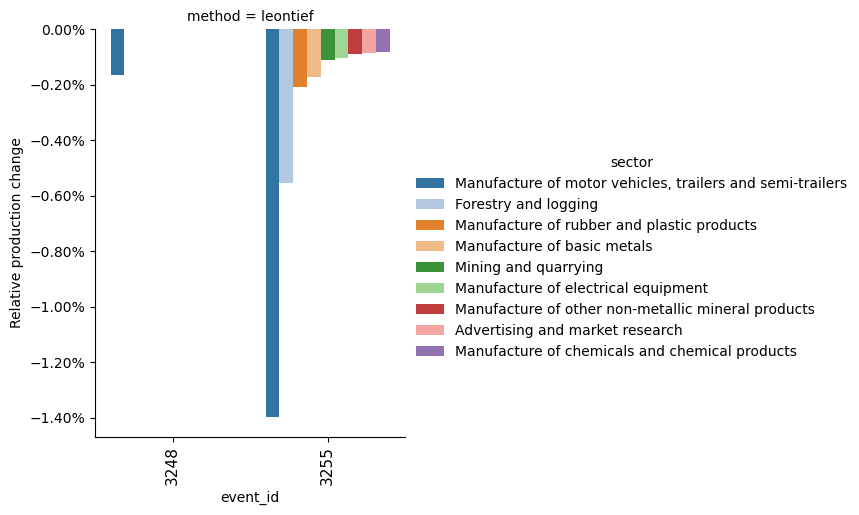

In [21]:
import seaborn as sns
from matplotlib.ticker import PercentFormatter

plot_df = res.copy()
plot_df = plot_df.loc[
    (plot_df["region"] == "JPN")
    & (plot_df["metric"] == "relative production change")
    & (plot_df["method"] == "leontief")
].sort_values("value").head(10)

g = sns.catplot(
    plot_df,
    kind="bar",
    x="event_id",
    y="value",
    hue="sector",
    row="method",
    #aspect=4,
    palette="tab20",
    # col = "metric"
)

g.set_ylabels("Relative production change")
g.axes.flat[0].yaxis.set_major_formatter(PercentFormatter(1))

# g.axes
g.set_xticklabels(g.axes[0, 0].get_xticklabels(), rotation=90, fontsize=11)

#### Top ten impacted sectors outside Japan (relative to their production), with the Leontief method:

Note how the impacts are two orders of magnitude bellow the previous ones.

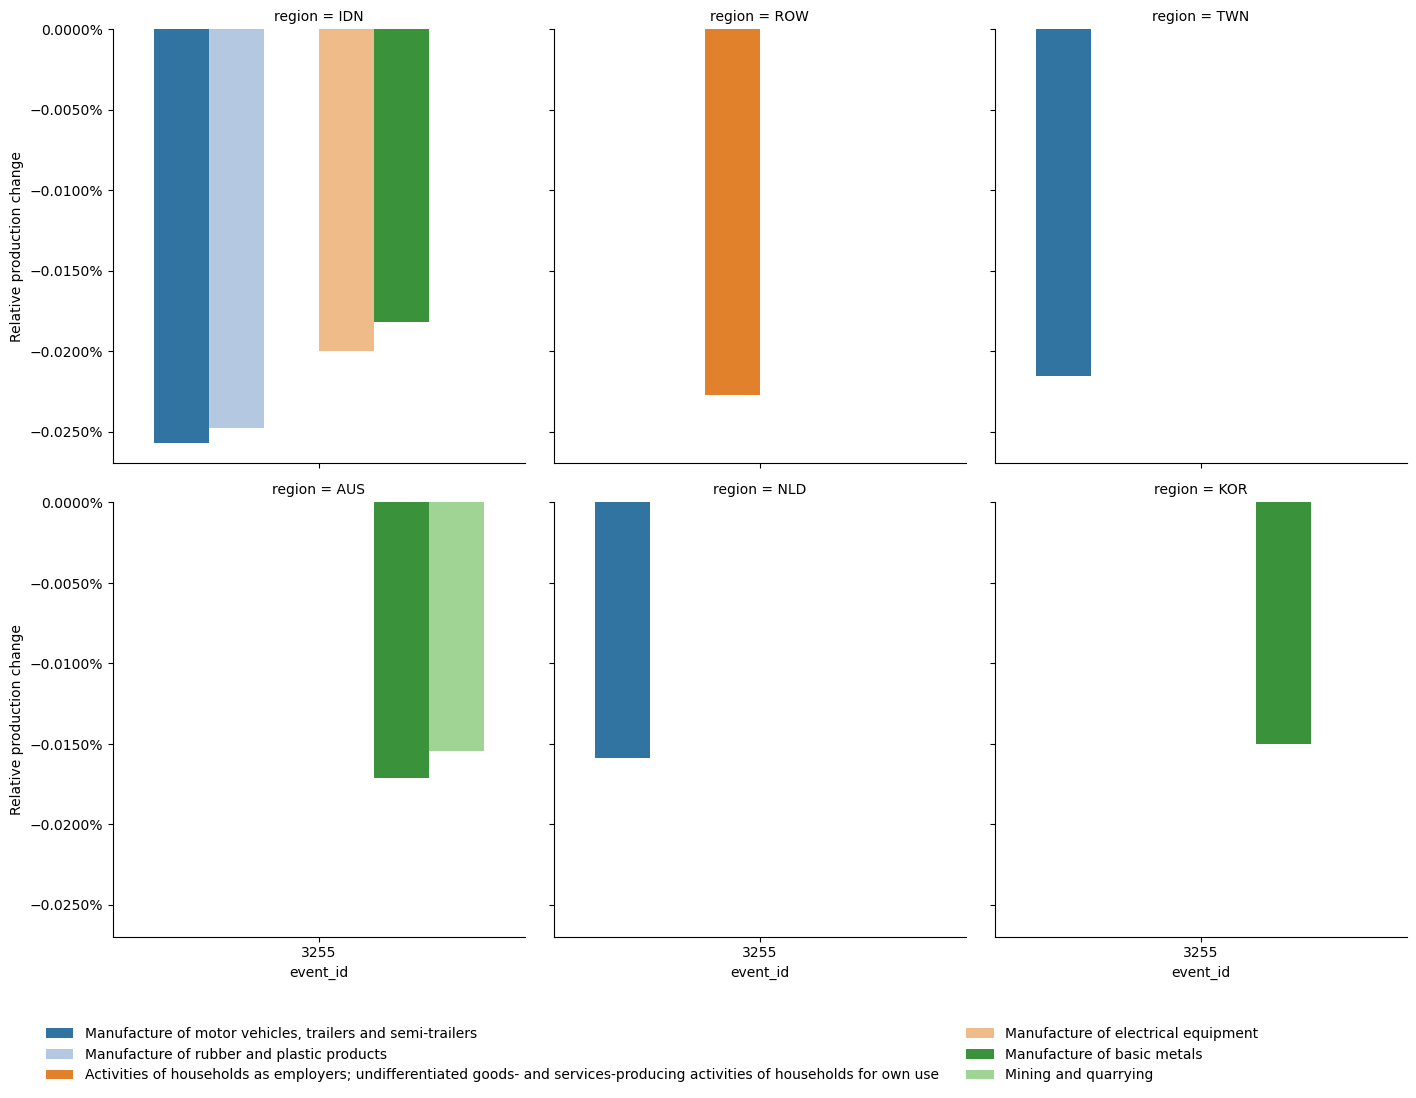

In [35]:
import seaborn as sns
from matplotlib.ticker import PercentFormatter

plot_df = res.copy()
plot_df = plot_df.loc[
    (plot_df["region"] != "JPN")
    & (plot_df["metric"] == "relative production change")
    & (plot_df["method"] == "leontief")
].sort_values("value").head(10)

g = sns.catplot(
    plot_df,
    kind="bar",
    x="event_id",
    y="value",
    hue="sector",
    col="region",
    col_wrap=3,
    palette="tab20",
)

sns.move_legend(g, "lower center",
    bbox_to_anchor=(.3, -0.1), ncol=2, title=None, frameon=False)

g.set_ylabels("Relative production change")
g.axes.flat[0].yaxis.set_major_formatter(PercentFormatter(1))

### Dynamic models

Static I-O models simply compute the change in equilibrium due to a shock. As such the recovery phase (and possible arising complications) is not accounted for.

Dynamic models fill this gap. There is a vast literature on the subject as many types of model exists, and it cannot be summarised within this workshop notebook. 
In addition, only the ARIO model is currently available within the module, via the `boario` package.

If you are interested feel free to get in touch, and I can also suggest these two reviews: 

1. Botzen et al. 2019. https://www.journals.uchicago.edu/doi/10.1093/reep/rez004
2. Coronese, Luzatti. 2022. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4101276

#### ARIO with `BoARIO`

Disclaimer: 

The development of BoARIO 0.6 and this supplychain module are being done in parallel. Notably because this new version of BoARIO implements major changes that a) facilitate coupling and b) will break retrocompatibility. 

The this new version is also a huge overhaul of the model engine, which is not yet fully debugged, and a lot of features are still broken. 

Thus, this part of the handout is more of a showcasing of the limited aspects that are working (or at least running).

Feel free to change the code to try out other impacts or feature, but expect bugs!

-------------------------------

The ARIO model offers a more "advanced" approach to compute indirect impacts. To understand more about the model we refer you to its seminal papers [Hallegatte 2008](https://doi.org/10.1111/j.1539-6924.2008.01046.x) and [Hallegatte 2013](https://doi.org/10.1111/risa.12090), as well as [the documentation](https://spjuhel.github.io/BoARIO/boario-what-is.html) of the `boario` package which is the implementation used in CLIMADA.

`boario` implements different kind of events, to account for a broad typology of impacts:
- `recovery` events, where the direct impact is translated into a loss of production capacity which is recovered over time exogenously.
- `rebuild` events, where the direct impact is translated into a loss of productive capital (assets) resulting in a loss of production capacity. In this case assets are also recovered over time, but through an endogenous reconstruction, which involves an additional final demand in the model.

For more details, we again refer to the `boario` documentation on [How to define events](https://spjuhel.github.io/BoARIO/tutorials/boario-events.html)

In [44]:
# We redefine a direct shock on all sectors this time
direct_shocks = DirectShocksSet.from_exp_and_imp(
    mriot,
    exp_jpn,
    direct_impact_jpn,
    shock_name="TCs in JPN",
    affected_sectors="all",
    impact_distribution=None,
)

NameError: name 'DirectShock' is not defined

There are multiple things that can be paramterized within `boario`, the simulation itself, as well as the model and the events. 

These parameters are passed to the package using three dictionnary read as kwargs by the different modules/classes of the boario package. This aspect still requires work as some parameters configurations may conflict with the coupling.

If you want to dig deeper, have a look at:

- https://spjuhel.github.io/BoARIO/tutorials/simulation-context.html and https://spjuhel.github.io/BoARIO/develop/en/_autosummary/boario.simulation.Simulation.html for simulation parameters
- https://spjuhel.github.io/BoARIO/develop/en/_autosummary/boario.extended_models.ARIOPsiModel.html for the model
- https://spjuhel.github.io/BoARIO/develop/en/_autosummary/boario.event.html for the events

<div class="alert alert-info">

We raise your attention on several important points:

The use of `boario`, although it offers more depth in results and in modelling possibilities, also requires you to configure it more than the previous approaches. For this a good understanding of the model is required.
The purpose of this tutorial is to show what is available in CLIMADA, but it does not replace an extensive reading about the model, its assumptions and its limitations.

Some options for `boario` are set by default either by CLIMADA or BoARIO, if you do not specify them. This ***does not mean*** that these default values are good in general as no generic case exists.
You should get familiar with the parameters and reflect on what choices are fitting for your case.

`boario` computations are much longer with respect to the previous approach. A progress bar is shown by default which indicates the estimated time a simulation requires. This time is highly dependent on:
- The size of the MRIOT used (number of regions x number of sectors)
- The number of events to simulate

</div>

In [36]:
dyn_model = BoARIOModel(
    mriot,
    direct_shocks,
    simulation_kwargs={"show_progress": True},
    model_kwargs={"order_type": "alt"},
    event_kwargs={"recovery_tau": 180},
)

/home/sjuhel/miniforge3/envs/petals_supply_chain/lib/python3.11/site-packages/boario/model_base.py:180: UserWarning: Custom monetary factor found in the IOSystem, continuing with this one (1000000)
  warnings.warn(


2025-02-11 15:24:24,605 - climada_petals.engine.supplychain.core - WARNING - Impact for following events was too small to have an effect, skipping them for efficiency: [249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 3232, 3233, 3234, 3235, 3237, 3238, 3239, 3240, 3241, 3245, 3246, 3247, 3249, 3251, 3252, 3256, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869]


The time required to run the simulation heavily depends on the MRIOTs (the number of regions * sectors), and the number of steps to simulate of course. 
With WIOD and the choosen events, it should take around 2 minutes on a recent computer.
EXIOBASE 3 is more in the 30-45 minutes range.
An estimate of the progress should be shown during the simulation.

In [37]:
res = dyn_model.run_sim()

Processed: Step: 725 ~ 100% Time:  0:03:12                 
Processed: Step: 725 ~ 100% Time:  0:03:12                 

`res` contains a Simulation object from `boario` which among other things contains all the time series of the state variables.

For instance you can plot the `production_realised` in relative terms using the following:

<Axes: xlabel='step'>

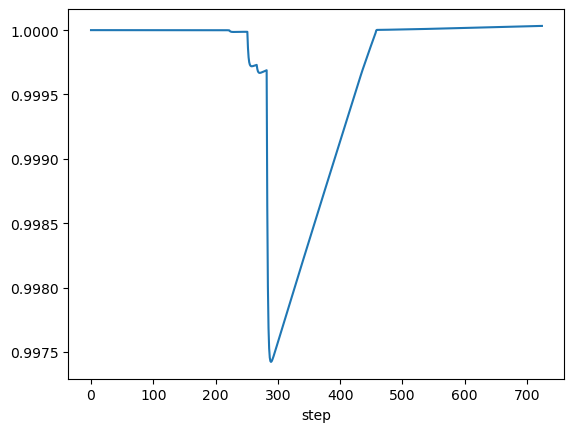

In [38]:
(res.production_realised / res.production_realised.loc[0]).loc[
    :, ("JPN", "Manufacture of basic metals")
].plot(legend=False)